In [1]:
%pip install boto3 --upgrade
%pip install botocore --upgrade
%pip install emr-notebooks-magics --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
sc.install_pypi_package('matplotlib')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1685655474483_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sc.install_pypi_package('pandas')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql.functions import date_format
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from numpy import ceil, floor

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Wczytanie danych

In [8]:
posts_df        = spark.read.parquet('s3://my-project-213242/cleaned/Posts/')
comments_df     = spark.read.parquet('s3://my-project-213242/cleaned/Comments/')
badges_df       = spark.read.parquet('s3://my-project-213242/cleaned/Badges/')
tags_df         = spark.read.parquet('s3://my-project-213242/cleaned/Tags/')
users_df        = spark.read.parquet('s3://my-project-213242/cleaned/Users/') 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1. Liczba postów na przestrzeni czasu

- wszystkich postów, bez rodzielenia na typ postu

In [9]:
df = (
    posts_df
        .withColumn('year', F.year(F.to_date('CreationDate')))
        .select('year')
        .groupBy('year')
        .count()
        .orderBy('year')
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+
|year|count|
+----+-----+
|2011|  570|
|2012| 4191|
|2013| 4965|
|2014| 5405|
|2015| 7167|
|2016| 9545|
|2017|10079|
|2018| 6496|
|2019| 6261|
|2020| 3765|
|2021| 2375|
|2022| 1955|
|2023|  300|
+----+-----+

- wszystkich postów, z podziałem na typ postu

In [10]:
df = (
    posts_df
    .withColumn('year', F.year(F.to_date('CreationDate')))
    .select('year', 'PostTypeId')
    .groupBy('year')
    .pivot('PostTypeId')
    .count()
    .orderBy('year')
    .withColumnRenamed('1', 'Question')
    .withColumnRenamed('2', 'Answer')
    .withColumnRenamed('4', 'Tag_wiki_excerpt')
    .withColumnRenamed('5', 'Tag_wiki')
    .withColumnRenamed('6', 'Moderator_nomination')
    .withColumnRenamed('7', 'Wiki_placeholder')
    .fillna(0)
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+------+----------------+--------+--------------------+----------------+
|year|Question|Answer|Tag_wiki_excerpt|Tag_wiki|Moderator_nomination|Wiki_placeholder|
+----+--------+------+----------------+--------+--------------------+----------------+
|2011|     194|   261|              57|      57|                   0|               1|
|2012|    1343|  2218|             315|     315|                   0|               0|
|2013|    1659|  2717|             293|     293|                   0|               3|
|2014|    1799|  3266|             170|     170|                   0|               0|
|2015|    2395|  4289|             235|     235|                  12|               1|
|2016|    3222|  5399|             462|     462|                   0|               0|
|2017|    3693|  5948|             219|     219|                   0|               0|
|2018|    2435|  3706|             173|     173|                   9|               0|
|2019|    2289|  3726|             123|    

#### (lineplot/barplot)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

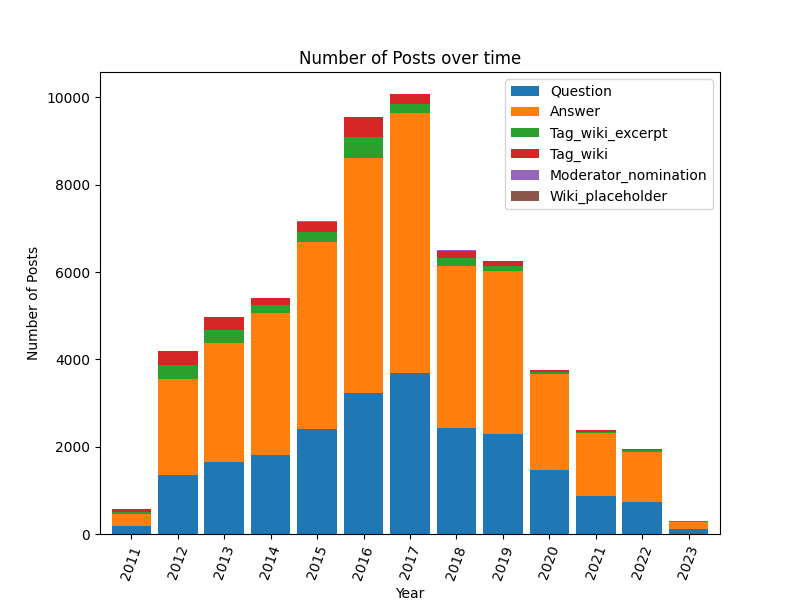

In [11]:
plt.clf()
df_plot = df.toPandas().set_index('year')
df_plot.plot.bar(stacked=True, width=0.85, rot=70, figsize=(8,6))
plt.title('Number of Posts over time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
%matplot plt

### 2. Czas na forum (od pojawienia się użytkownika do ostatniego posta/komentarza) 

- ostatnia aktywność użytkowników dla tworzenia postów

In [12]:
last_posts_activity_df = posts_df\
            .select('CreationDate', 'OwnerUserId')\
            .groupBy('OwnerUserId')\
            .agg(F.max('CreationDate').alias('LastPostDate'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- ostatnia aktywność użytkowników dla tworzenia komentarzy

In [13]:
last_comments_activity_df = comments_df\
            .select('CreationDate', 'UserId')\
            .groupBy('UserId')\
            .agg(F.max('CreationDate').alias('LastCommentDate'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- 10 najdłużej aktywnych użytkowników (pomijając boty)

In [14]:
df = (
    users_df
        .select('Id', 'CreationDate', 'DisplayName')
        .where(F.col('Id')>0)
        .join(
            last_posts_activity_df,
            users_df.Id == last_posts_activity_df.OwnerUserId,
            "left"
            )
        .join(
            last_comments_activity_df,
            users_df.Id == last_comments_activity_df.UserId,
            "left")
        .select('Id', 'DisplayName', 'CreationDate', F.greatest(F.col('LastPostDate'), F.col('LastCommentDate')).alias('LastActivity'))
        .dropna('any')
        .withColumn('ActiveTime_s', F.unix_timestamp(F.col('LastActivity')) - F.unix_timestamp(F.col('CreationDate')))
        .orderBy(F.col('ActiveTime_s').desc()).limit(10)
        .withColumn('ActiveTime_year', F.round(F.col('ActiveTime_s')/60/60/24/365.25, 3))
)

df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------------------------+-----------------------+-----------------------+------------+---------------+
|Id  |DisplayName                |CreationDate           |LastActivity           |ActiveTime_s|ActiveTime_year|
+----+---------------------------+-----------------------+-----------------------+------------+---------------+
|40  |iandotkelly                |2011-11-30 19:25:58.58 |2023-02-22 22:56:10.11 |354425412   |11.231         |
|49  |Napoleon Wilson            |2011-11-30 20:07:52.243|2023-02-19 11:53:18.733|354123926   |11.222         |
|106 |Shadow Wizard Chasing Stars|2011-12-01 09:15:02.08 |2023-02-13 16:10:45.06 |353573743   |11.204         |
|134 |matt_black                 |2011-12-01 22:17:08.107|2023-02-12 20:56:43.75 |353457575   |11.2           |
|667 |bitmask                    |2012-01-23 15:11:28.323|2023-03-04 11:35:54.953|350598266   |11.11          |
|763 |Shiz Z.                    |2012-02-04 16:44:13.883|2023-02-18 21:28:26.827|348381853   |11.04    

#### (barplot)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

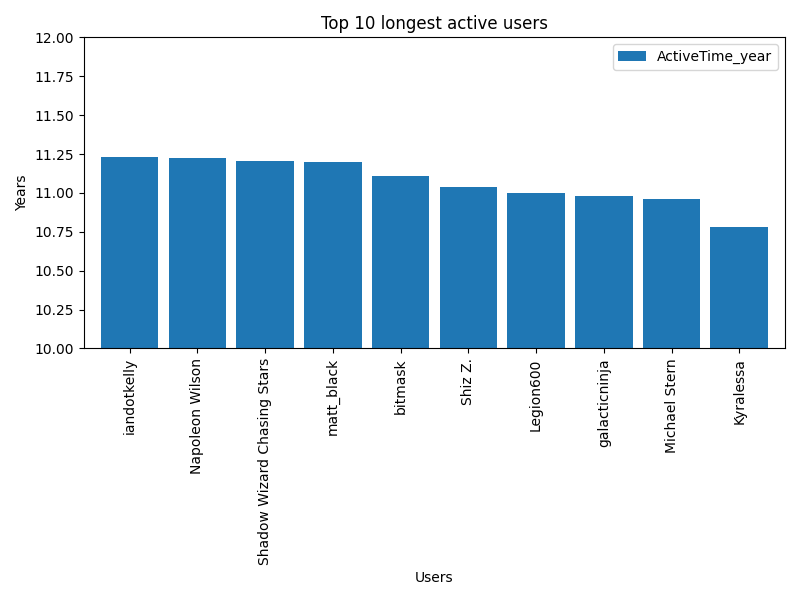

In [15]:
plt.clf()
df_plot = df.select('DisplayName', 'ActiveTime_year').toPandas().set_index('DisplayName')
df_plot.plot.bar( width=0.85, rot=90, figsize=(8,6))
plt.title('Top 10 longest active users')
plt.ylim(floor(df_plot['ActiveTime_year'].min()), ceil(df_plot['ActiveTime_year'].max()))
plt.ylabel('Years')
plt.xlabel('Users')
plt.tight_layout()

%matplot plt

### 3. Porównanie najwyżej i najniżej ocenianych pytań (długość, tagi, liczba odpowiedzi)

In [16]:
df = (
    posts_df
        .filter(F.col('PostTypeId') == 1)
        .select('Id','AnswerCount', 'Title', 'Body', 'Tags', 'Score')
        .withColumn('TitleLength', F.size(F.col('Title')))
        .withColumn('BodyLength', F.size(F.col('Body')))
        .withColumn('TagsLength', F.size(F.col('Tags')))
        .select('Id','AnswerCount', 'TitleLength', 'BodyLength', 'TagsLength', 'Score')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- najwyżej oceniane pytania

In [17]:
df_best = df.orderBy(F.col('Score').desc()).limit(50)
df_best.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------+-----------+----------+----------+-----+
|Id   |AnswerCount|TitleLength|BodyLength|TagsLength|Score|
+-----+-----------+-----------+----------+----------+-----+
|79161|1          |6          |49        |4         |246  |
|2190 |6          |4          |36        |1         |223  |
|604  |7          |8          |49        |3         |201  |
|827  |8          |6          |22        |3         |184  |
|9745 |3          |7          |35        |2         |168  |
|77942|2          |3          |43        |1         |158  |
|130  |4          |7          |45        |3         |157  |
|70815|7          |4          |40        |3         |146  |
|84846|6          |5          |40        |3         |141  |
|62533|7          |3          |35        |3         |140  |
|47516|10         |6          |73        |2         |139  |
|53408|1          |3          |48        |3         |131  |
|83382|7          |8          |23        |1         |131  |
|84503|4          |6          |13       

In [18]:
df_best.agg(
    F.mean(F.col('AnswerCount')).alias('AnswerCount_avg'),
    F.mean(F.col('TitleLength')).alias('TitleLength_avg'),
    F.mean(F.col('BodyLength')).alias('BodyLength_avg'),
    F.mean(F.col('TagsLength')).alias('TagsLength_avg'),
    F.mean(F.col('Score')).alias('Score_avg'),
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------------+--------------+--------------+---------+
|AnswerCount_avg|TitleLength_avg|BodyLength_avg|TagsLength_avg|Score_avg|
+---------------+---------------+--------------+--------------+---------+
|           4.82|            5.5|          48.1|          2.08|   119.98|
+---------------+---------------+--------------+--------------+---------+

- najniżej oceniane pytania

In [19]:
df_worst = df.orderBy(F.col('Score').asc()).limit(50)
df_worst.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----------+-----------+----------+----------+-----+
|Id    |AnswerCount|TitleLength|BodyLength|TagsLength|Score|
+------+-----------+-----------+----------+----------+-----+
|72850 |1          |2          |35        |3         |-24  |
|97868 |1          |9          |13        |2         |-18  |
|73060 |2          |4          |27        |2         |-15  |
|57003 |1          |6          |8         |2         |-14  |
|97898 |1          |8          |37        |4         |-13  |
|98499 |1          |5          |14        |2         |-12  |
|59896 |1          |4          |43        |2         |-11  |
|78871 |1          |10         |68        |1         |-11  |
|98361 |1          |3          |23        |2         |-11  |
|63480 |2          |4          |7         |2         |-10  |
|83193 |2          |5          |73        |2         |-10  |
|88875 |1          |5          |16        |2         |-10  |
|92863 |2          |3          |34        |2         |-10  |
|97956 |1          |4   

In [20]:
df_worst.agg(
    F.mean(F.col('AnswerCount')).alias('AnswerCount_avg'),
    F.mean(F.col('TitleLength')).alias('TitleLength_avg'),
    F.mean(F.col('BodyLength')).alias('BodyLength_avg'),
    F.mean(F.col('TagsLength')).alias('TagsLength_avg'),
    F.mean(F.col('Score')).alias('Score_avg'),
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------------+--------------+--------------+---------+
|AnswerCount_avg|TitleLength_avg|BodyLength_avg|TagsLength_avg|Score_avg|
+---------------+---------------+--------------+--------------+---------+
|           1.32|           5.46|         49.82|           2.1|    -8.94|
+---------------+---------------+--------------+--------------+---------+

### 4. Procent przypadków kiedy najwyżej oceniana odpowiedź to niezaakceptowana odpowiedź

- pytania, w których zaakceptowano jakąś odpowiedź

In [21]:
questions_df = (
    posts_df
    .filter((F.col('AcceptedAnswerId') > 0) & (F.col('PostTypeId') == 1))
    .select('AcceptedAnswerId', 'Id')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- najlepiej oceniane odpowiedzi (`bestAnswer_Id`) w odpowiedzi na pytania (`bestAnswer_ParentId`)

In [22]:
from pyspark.sql.window import Window

windowSpec  = Window.partitionBy("ParentId").orderBy(F.col("Score").desc())

answers_df = (
    posts_df
    .filter(F.col('PostTypeId') == 2)
    .select('ParentId', 'Id', 'Score')
    .withColumn("rank", F.rank().over(windowSpec))
    .filter(F.col('rank')==1)
    .drop('rank', 'Score')
    .withColumnRenamed('Id', 'bestAnswer_Id')
    .withColumnRenamed('ParentId', 'bestAnswer_ParentId')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- procent przypadków kiedy najwyżej oceniana odpowiedź to niezaakceptowana odpowiedź

In [23]:
df = (
    questions_df
    .join(answers_df, questions_df.Id == answers_df.bestAnswer_ParentId, 'left')
    .withColumn('flag', F.when(F.col('AcceptedAnswerId') != F.col('bestAnswer_Id') , 1).otherwise(0))
    .select(F.mean(F.col('flag')*100).alias('%'))
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|                %|
+-----------------+
|7.024191197901486|
+-----------------+

### 5. Rozkład ocen odpowiedzi zaakceptowanych vs pozostałych (średnia, odchylenie, minimum, maksimum)

- odpowiedzi (`Id`) oraz ich ocena (`Score`) wraz z informacją czy jest to zaakceptowana odpowiedź (`AcceptedAnswer`)

In [24]:
df = (
    posts_df.filter(F.col('PostTypeId') == 2)
    .select('Id', 'Score')
    .join(
        posts_df.filter(F.col('PostTypeId') == 1)
        .select(F.col('AcceptedAnswerId')), 
        posts_df.Id == posts_df.AcceptedAnswerId,
        'left'
         )
    .withColumn('AcceptedAnswer', F.when(F.col('AcceptedAnswerId')>0, 1).otherwise(0))
    .drop('AcceptedAnswerId')   
)

df.limit(10).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+--------------+
| Id|Score|AcceptedAnswer|
+---+-----+--------------+
|  2|   15|             0|
|  8|    8|             0|
| 17|   14|             0|
| 21|   13|             1|
| 24|    9|             0|
| 25|    8|             0|
| 31|   17|             1|
| 32|   16|             0|
| 34|    8|             1|
| 36|   16|             0|
+---+-----+--------------+

- średnia, odchylenie, minimum, maksimum

In [25]:
stats_df = (
     df
        .groupBy('AcceptedAnswer')
        .agg(
            F.round(F.mean('Score'), 2).alias('mean'),
            F.round(F.stddev('Score'), 2).alias('std'),
            F.min('Score').alias('min'),
            F.max('Score').alias('max')
    )
)

stats_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+-----+---+---+
|AcceptedAnswer| mean|  std|min|max|
+--------------+-----+-----+---+---+
|             1|12.14|15.76|-11|326|
|             0| 4.91| 9.06|-10|215|
+--------------+-----+-----+---+---+

### 6.Top N tagów które wygenerowały najwięcej wyświetleń

- ustalenie wartości N

In [26]:
n = 10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- najwiecej wyswietlen w skali jednego posta

In [27]:
from pyspark.sql.window import Window
windowSpec  = Window.partitionBy("Tag").orderBy(F.col("ViewCount").desc())

top_tags_df = (
    posts_df
    .filter(F.col('PostTypeId') == 1)
    .select('ViewCount', F.explode('Tags').alias('Tag'))
    .withColumn("rank", F.rank().over(windowSpec))
    .filter(F.col("rank")==1)
    .drop("rank")
    .orderBy(F.col('ViewCount').desc())
    .limit(n)
)

top_tags_df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------------+
|ViewCount|Tag                  |
+---------+---------------------+
|1525046  |harry-potter         |
|1353541  |plot-explanation     |
|1353541  |the-lord-of-the-rings|
|907158   |shadowhunters        |
|760256   |memento              |
|747037   |american-psycho      |
|703444   |suggested-order      |
|703444   |the-hobbit           |
|530416   |historical-accuracy  |
|530416   |the-last-kingdom     |
+---------+---------------------+

- suma wszystkich wyswietleń dla wszystkich postów dla top N tagów

In [28]:
top_tags2_df = (
    posts_df
    .filter(F.col('PostTypeId') == 1)
    .select('ViewCount', F.explode('Tags').alias('Tag'))
    .groupBy('Tag').agg(F.sum(F.col('ViewCount')).alias('SumViewCount'))
    .orderBy(F.col('SumViewCount').desc())
    .limit(n)
)

top_tags2_df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+------------+
|Tag                      |SumViewCount|
+-------------------------+------------+
|plot-explanation         |67493057    |
|character                |19233425    |
|analysis                 |13512498    |
|marvel-cinematic-universe|10990509    |
|ending                   |8077492     |
|dialogue                 |7623430     |
|game-of-thrones          |6673811     |
|breaking-bad             |5506396     |
|film-techniques          |4740492     |
|production               |4434326     |
+-------------------------+------------+

### 7. Liczba postów w czasie dla każdego z top N tagów (lineplot/barplot)

- dla tagów które wygenerowały najwiecej wyswietlen w skali jednego posta

In [29]:
df = (
    posts_df
    .filter(F.col('PostTypeId') == 1)
    .select('CreationDate', F.explode('Tags').alias('Tag'))
    .join(top_tags_df.select('Tag'), 'Tag', 'inner')
    .withColumn('date', F.to_date('CreationDate'))
    .withColumn('year', F.year('date'))
    .groupBy('year')
    .pivot('Tag')
    .count()
    .orderBy('year')
    .fillna(0)
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------------+------------+-------------------+-------+----------------+-------------+---------------+----------+----------------+---------------------+
|year|american-psycho|harry-potter|historical-accuracy|memento|plot-explanation|shadowhunters|suggested-order|the-hobbit|the-last-kingdom|the-lord-of-the-rings|
+----+---------------+------------+-------------------+-------+----------------+-------------+---------------+----------+----------------+---------------------+
|2011|              0|           4|                  1|      1|              61|            0|              1|         0|               0|                    0|
|2012|              0|           5|                 10|      5|             539|            0|              1|        10|               0|                   13|
|2013|              2|          12|                  6|      5|             533|            0|              0|        21|               0|                   17|
|2014|              3|           7

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

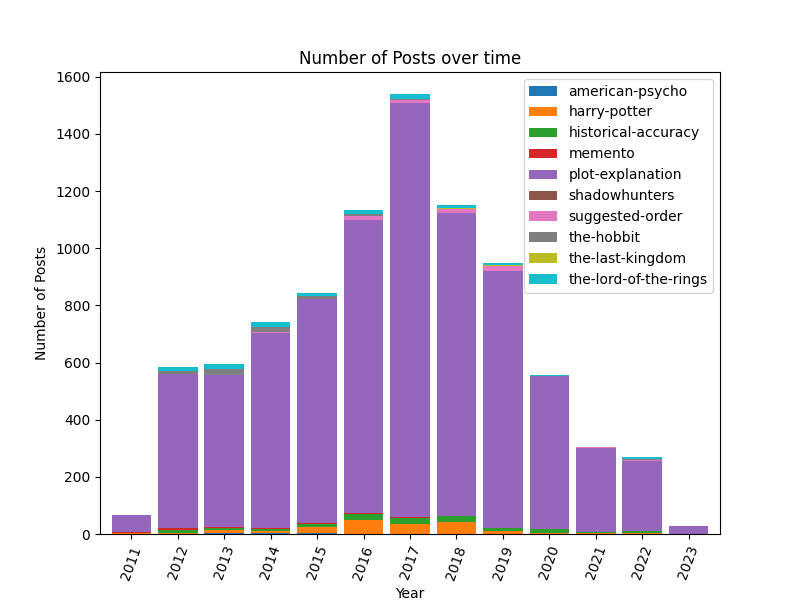

In [30]:
plt.clf()
df_plot = df.toPandas().set_index('year')
df_plot.plot.bar(stacked=True, width=0.85, rot=70, figsize=(8,6))
plt.title('Number of Posts over time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')

%matplot plt

- dla tagów które sumarycznie wygenerowały najwięcej wyświetleń wszystkich postów

In [31]:
df = (
    posts_df
    .filter(F.col('PostTypeId') == 1)
    .select('CreationDate', F.explode('Tags').alias('Tag'))
    .join(top_tags2_df.select('Tag'), 'Tag', 'inner')
    .withColumn('date', F.to_date('CreationDate'))
    .withColumn('year', F.year('date'))
    .groupBy('year')
    .pivot('Tag')
    .count()
    .orderBy('year')
    .fillna(0)
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+------------+---------+--------+------+---------------+---------------+-------------------------+----------------+----------+
|year|analysis|breaking-bad|character|dialogue|ending|film-techniques|game-of-thrones|marvel-cinematic-universe|plot-explanation|production|
+----+--------+------------+---------+--------+------+---------------+---------------+-------------------------+----------------+----------+
|2011|      41|           0|       13|       3|     9|              5|              0|                        1|              61|         1|
|2012|     143|           8|      110|      36|    34|             39|              8|                       29|             539|        29|
|2013|     143|          77|      188|      35|    28|             67|             36|                       46|             533|        50|
|2014|     146|          52|      150|      75|    24|             58|             41|                       50|             682|        51|
|2015|     12

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

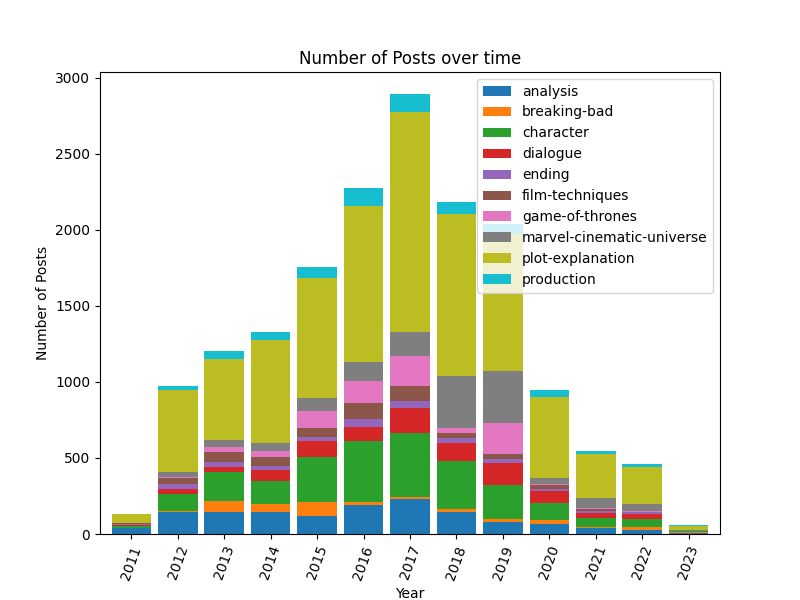

In [32]:
plt.clf()
df_plot = df.toPandas().set_index('year')
df_plot.plot.bar(stacked=True, width=0.85, rot=70, figsize=(8,6))
plt.title('Number of Posts over time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')

%matplot plt

### 8. Najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords)

In [33]:
top_words_df = (
    posts_df
    .filter(F.col('PostTypeId') == 1)
    .select(F.explode('Title').alias('word'))
    .groupBy('word').count()
    .orderBy(F.col('count').desc())
)

top_words_df.limit(20).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+
|        word|count|
+------------+-----+
|       movie| 1584|
|       scene|  655|
|         end|  573|
|         get|  552|
|        know|  550|
|         man|  494|
|       first|  489|
|        film|  475|
|      movies|  456|
|   character|  431|
|significance|  430|
|          tv|  411|
|        time|  408|
|    happened|  381|
|        name|  377|
|      season|  365|
|        mean|  355|
|        show|  353|
|         use|  352|
|        real|  337|
+------------+-----+

### 9. Procent użytkowników którzy nigdy nic nie zapostowali

In [34]:
df = (
    users_df
    .select('Id')
    .join(posts_df.select('OwnerUserId').distinct(), users_df.Id == posts_df.OwnerUserId, 'left')
    .withColumn('withNoPost', F.when(F.col('OwnerUserId').isNull(), 1).otherwise(0))
    .select(F.mean(F.col('withNoPost')*100).alias('%'))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|                %|
+-----------------+
|78.99806517169861|
+-----------------+

### 10. Średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

- zaakcepowana odpowiedź (`AcceptedAnswerId`) dla pytania (`QuestionId`), utworzonego w (`QuestionCreationDate`)

In [36]:
questions_df =(
    posts_df
    .filter((F.col('PostTypeId') == 1) & (F.col('AcceptedAnswerId') > 0))
    .select('AcceptedAnswerId',
            F.col('CreationDate').alias('QuestionCreationDate'),
            F.col('Id').alias('QuestionId'))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- odpowiedź (`AnswerId`) utworzonego w (`AnswerCreationDate`)

In [37]:
answers_df =(
    posts_df
    .filter(F.col('PostTypeId') == 2)
    .select(F.col('Id').alias('AnswerId'),
            F.col('CreationDate').alias('AnswerCreationDate'))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- Średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

In [38]:
df = (
    questions_df
    .join(answers_df, questions_df.AcceptedAnswerId == answers_df.AnswerId, 'left')
    .withColumn('WaitingTimeDays', (F.unix_timestamp(F.col('AnswerCreationDate')) - F.unix_timestamp(F.col('QuestionCreationDate')))/60/60/24)
    .select(F.mean(F.col('WaitingTimeDays')).alias('WaitingTimeDays_avg'))
)

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|WaitingTimeDays_avg|
+-------------------+
|  31.49515632398322|
+-------------------+